In [2]:
%pylab inline
from qualityBaseline import *
from analysis_toolbox import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
img_info,object_tbl,bb_info,hit_info = load_info()

In [73]:
from collections import OrderedDict
img_info,object_tbl,bb_info,hit_info = load_info()
bb_info =bb_info[bb_info["object_id"]==10]
for bb in tqdm(list(bb_info.iterrows())):
    oid = bb[1]["object_id"]
    #Image information 
    image_id = int(object_tbl[object_tbl.object_id==oid].image_id)
    img_name = img_info["filename"][image_id-1]

    bbx_path= bb[1]["x_locs"]
    bby_path= bb[1]["y_locs"]
    worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
    worker_x_locs,worker_y_locs = zip(*list(OrderedDict.fromkeys(zip(worker_x_locs,worker_y_locs))))

In [6]:
import warnings
warnings.filterwarnings("ignore")

from scipy.interpolate import splprep,splev
def single_parametric_interpolate(obj_x_loc,obj_y_loc,numPts=50,PLOT=False):
    '''
    Interpolate a single given bounding box obj_x_loc,obj_y_loc
    return a new set of coordinates interpolated on numPts 
    '''
    tck, u =splprep(np.array([obj_x_loc,obj_y_loc]),s=0,per=1)
    u_new = np.linspace(u.min(),u.max(),numPts)
    new_points = splev(u_new, tck,der=0)
    return new_points

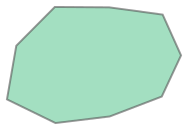

In [20]:
ixlocs,iylocs = single_parametric_interpolate(worker_x_locs,worker_y_locs,numPts=10)
icoord = np.array(zip(ixlocs,iylocs))
Polygon(icoord)

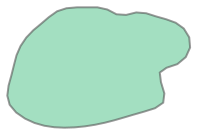

In [21]:
ixlocs,iylocs = single_parametric_interpolate(worker_x_locs,worker_y_locs,numPts=50)
icoord = np.array(zip(ixlocs,iylocs))
Polygon(icoord)

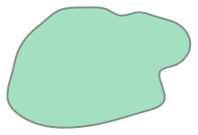

In [19]:
ixlocs,iylocs = single_parametric_interpolate(worker_x_locs,worker_y_locs,numPts=1000)
icoord = np.array(zip(ixlocs,iylocs)) #interpolated coordinates
Polygon(icoord)

In [82]:
def single_randomwalk_interpolate(obj_x_loc,obj_y_loc,numPts=50):
    n = len(obj_x_loc)
    vi = [[obj_x_loc[(i+1)%n] - obj_x_loc[i],
         obj_y_loc[(i+1)%n] - obj_y_loc[i]] for i in range(n)]
    si = [np.linalg.norm(v) for v in vi]
    di = np.linspace(0, sum(si), numPts, endpoint=False)
    new_points = []
    for d in di:
        for i,s in enumerate(si):
            if d>s: d -= s
            else: break
        l = d/s
        new_points.append([obj_x_loc[i] + l*vi[i][0],
                           obj_y_loc[i] + l*vi[i][1]])
    return new_points

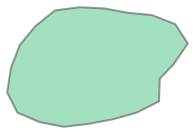

In [84]:
ixylocs = single_randomwalk_interpolate(worker_x_locs,worker_y_locs,numPts=20)
icoord = np.array(ixylocs)
Polygon(icoord)

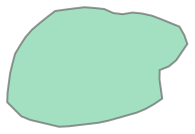

In [87]:
ixylocs = single_randomwalk_interpolate(worker_x_locs,worker_y_locs,numPts=50)
icoord = np.array(ixylocs)
Polygon(icoord)

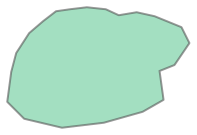

In [89]:
ixylocs = single_parametric_interpolate(worker_x_locs,worker_y_locs,numPts=1000)
icoord = np.array(ixylocs)
Polygon(icoord)

In [93]:
img_info,object_tbl,bb_info,hit_info = load_info()
bb_info =bb_info[bb_info["object_id"]==10]
coord_lst =[]
icoord_lst =[]
aicoord_lst =[]
for bb in tqdm(list(bb_info.iterrows())):
    oid = bb[1]["object_id"]
    #Image information 
    image_id = int(object_tbl[object_tbl.object_id==oid].image_id)
    img_name = img_info["filename"][image_id-1]

    bbx_path= bb[1]["x_locs"]
    bby_path= bb[1]["y_locs"]
    worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
    worker_x_locs,worker_y_locs = zip(*list(OrderedDict.fromkeys(zip(worker_x_locs,worker_y_locs))))
    coord_lst.append(zip(worker_x_locs,worker_y_locs))
    
    ixylocs = single_randomwalk_interpolate(worker_x_locs,worker_y_locs)
    icoord = np.array(ixylocs) #interpolated coordinates
    icoord_lst.append(icoord)
    # find point with min distance to origin
    oidx=np.argmin(sqrt(icoord[:,0]**2+icoord[:,1]**2))
#     print oidx
    # aligning coordinates
    try:
        next_coord  = icoord[oidx+1]
    except(IndexError):
        # oidx is last element of the array
        next_coord  = icoord[0]
    if icoord[oidx][0] <next_coord[0]:
#         print "CW"
        aicoord = np.concatenate((icoord[oidx:-1],icoord[:oidx]))
    else: 
#         print "CCW"
        aicoord = np.concatenate((icoord[:oidx-1][::-1],icoord[oidx:][::-1]))
    aicoord_lst.append(aicoord)

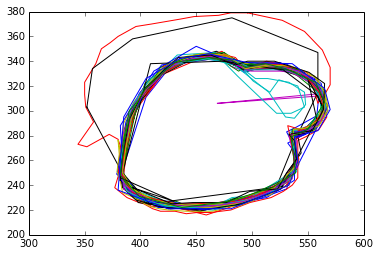

In [94]:
for xy in coord_lst:
    x,y = Polygon(xy).exterior.xy
    plt.plot(x,y)

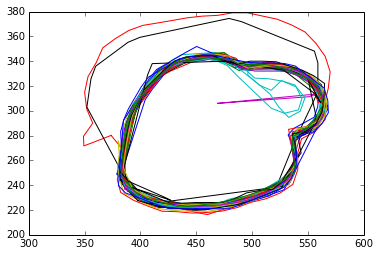

In [95]:
for xy in aicoord_lst:
    x,y = Polygon(xy).exterior.xy
    plt.plot(x,y)

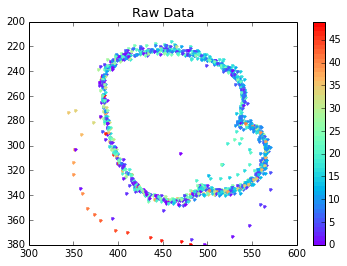

In [96]:
selected_idx=range(50)
steps = np.linspace(0, 1, len(selected_idx))
colors = cm.rainbow(steps)
Z = [[0,0],[0,0]]
CS3 = plt.contourf(Z, selected_idx, cmap=cm.rainbow)
plt.clf()
plt.colorbar(CS3) 
len_lst = []
for coord in coord_lst:
    len_lst.append(len(coord))
    for i in range(len(coord)):
        x,y = coord[i]
#         print i
        plt.plot(x,y,'.',color=colors[selected_idx.index(i)],label = "Point {}".format(i))    
plt.title("Raw Data",fontsize=13)
plt.gca().invert_yaxis()
plt.savefig('raw_data.pdf')

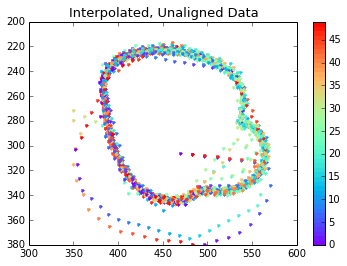

In [97]:
selected_idx=range(50)
steps = np.linspace(0, 1, len(selected_idx))
colors = cm.rainbow(steps)
Z = [[0,0],[0,0]]
CS3 = plt.contourf(Z, selected_idx, cmap=cm.rainbow)
plt.clf()
plt.colorbar(CS3)
len_lst = []
for coord in icoord_lst:
    len_lst.append(len(coord))
    for i in range(len(coord)):
        x,y = coord[i]
#         print i
        plt.plot(x,y,'.',color=colors[selected_idx.index(i)],label = "Point {}".format(i))    
plt.gca().invert_yaxis()
plt.title("Interpolated, Unaligned Data",fontsize=13)
plt.savefig('interpolated_unaligned_data.pdf')

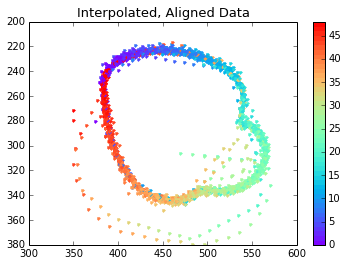

In [98]:
selected_idx=range(49)
steps = np.linspace(0, 1, len(selected_idx))
colors = cm.rainbow(steps)
Z = [[0,0],[0,0]]
CS3 = plt.contourf(Z, selected_idx, cmap=cm.rainbow)
plt.clf()
plt.colorbar(CS3)
colors = cm.rainbow(np.linspace(0, 1, len(selected_idx)))
for coord in aicoord_lst:
    for i in selected_idx:
        x,y = coord[i]
        plt.plot(x,y,'.',color=colors[selected_idx.index(i)],label = "Point {}".format(i))    
plt.gca().invert_yaxis()
plt.title("Interpolated, Aligned Data",fontsize=13)
plt.savefig('interpolated_aligned_data.pdf')

In [99]:
def interpolate_align_bb():
    '''
    Interpolate and Align bounding boxes and save results to interpolated_aligned_bb_info.csv
    1. subsample 50 points 
    2. compute distance to origin 
    3. find point with min distance to origin 
    4. determine clockwise or counter clockwise by:
        seeing if the next array element is to the right of this point 
        concatenate the array portions accordingly 
    '''
    img_info,object_tbl,bb_info,hit_info = load_info()
    coord_lst =[]
    icoord_lst =[]
    aicoord_lst =[]
    aicoord_tbl=[]
    for bb in tqdm(list(bb_info.iterrows())):
        oid = bb[1]["object_id"]
        wid = bb[1]["worker_id"]
        #Image information 
        image_id = int(object_tbl[object_tbl.object_id==oid].image_id)
        img_name = img_info["filename"][image_id-1]

        bbx_path= bb[1]["x_locs"]
        bby_path= bb[1]["y_locs"]
        worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
        worker_x_locs,worker_y_locs = zip(*list(OrderedDict.fromkeys(zip(worker_x_locs,worker_y_locs))))
        coord_lst.append(zip(worker_x_locs,worker_y_locs))

        ixylocs = single_randomwalk_interpolate(worker_x_locs,worker_y_locs)
        icoord = np.array(ixylocs) #interpolated coordinates
        icoord_lst.append(icoord)
        # find point with min distance to origin
        oidx=np.argmin(sqrt(icoord[:,0]**2+icoord[:,1]**2))
        # aligning coordinates
        try:
            next_coord  = icoord[oidx+1]
        except(IndexError):
            # oidx is last element of the array
            next_coord  = icoord[0]
        if icoord[oidx][0] <next_coord[0]:
            # CW
            aicoord = np.concatenate((icoord[oidx:-1],icoord[:oidx]))
        else: 
            # CCW
            aicoord = np.concatenate((icoord[:oidx-1][::-1],icoord[oidx:][::-1]))
        aicoord_lst.append(aicoord)
        aicoord_tbl.append([oid,wid,str(list(aicoord[:,0])),str(list(aicoord[:,1]))])
    ai_tbl = pd.DataFrame(aicoord_tbl,columns=["object_id","worker_id","aix_locs","aiy_locs"])
    ai_tbl.to_csv("interpolated_aligned_bb_info.csv")
    return ai_tbl

In [100]:
ai_tbl = interpolate_align_bb()

In [101]:
def plot_interpolated_aligned_obj_data(oid,numPts=50):
    '''
    Plot the Interpolated aligned data for the object corresponding to the given oid 
    The colorbar indicates the index of the points 
    Should observe a perfect gradation when alignment is done right
    '''
    ai_tbl= pd.read_csv("interpolated_aligned_bb_info.csv",index_col=0)
    ai_tbl = ai_tbl[ai_tbl["object_id"]==oid]

    selected_idx=range(numPts-1)
    steps = np.linspace(0, 1, len(selected_idx))
    colors = cm.rainbow(steps)
    Z = [[0,0],[0,0]]
    CS3 = plt.contourf(Z, selected_idx, cmap=cm.rainbow)
    plt.clf()
    plt.colorbar(CS3)
    colors = cm.rainbow(np.linspace(0, 1, len(selected_idx)))
    for coord in ai_tbl.iterrows():
        x,y = process_raw_locs([coord[1]["aix_locs"],coord[1]["aiy_locs"]])
        coord = zip(x,y)
        for i in selected_idx:
            x,y = coord[i]
            plt.plot(x,y,'.',color=colors[selected_idx.index(i)],label = "Point {}".format(i))    
    plt.gca().invert_yaxis()
    plt.title("Interpolated, Aligned Data [Obj{}]".format(oid),fontsize=13)
    plt.savefig('interpolated_aligned_data_obj{}.pdf'.format(oid))

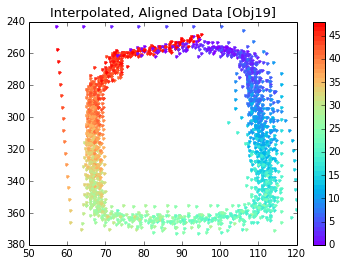

In [102]:
plot_interpolated_aligned_obj_data(19)

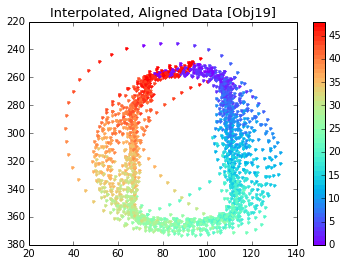

In [311]:
plot_interpolated_aligned_obj_data(19)

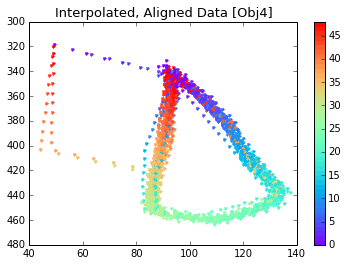

In [103]:
plot_interpolated_aligned_obj_data(4)

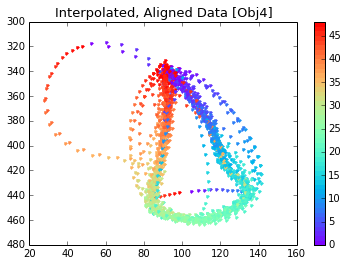

In [312]:
plot_interpolated_aligned_obj_data(4)

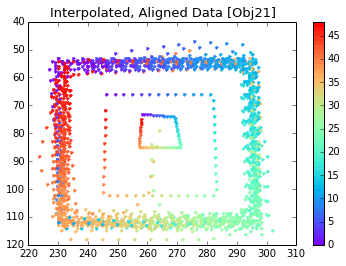

In [104]:
plot_interpolated_aligned_obj_data(21)

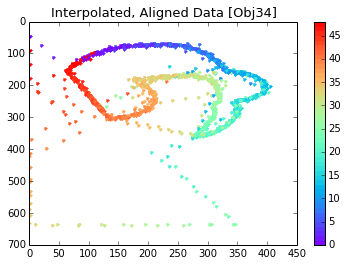

In [105]:
plot_interpolated_aligned_obj_data(34)

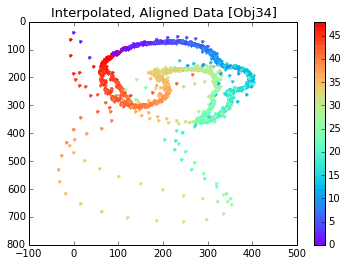

In [314]:
plot_interpolated_aligned_obj_data(34)

The random walk method preserves the original shape of the bounding box a lot better than in the spline parametric interpolation method